In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import time
from datetime import datetime
from google.cloud.logging import DESCENDING, Client
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18

In [4]:
gp.keys()

Index(['insertId', 'jsonPayload.blockHash', 'jsonPayload.contentLength',
       'jsonPayload.headSlot', 'jsonPayload.idArg', 'jsonPayload.level',
       'jsonPayload.method', 'jsonPayload.mevBoostV', 'jsonPayload.msIntoSlot',
       'jsonPayload.msg', 'jsonPayload.proposerPubkey', 'jsonPayload.service',
       'jsonPayload.slot', 'jsonPayload.slotStartSec',
       'jsonPayload.timestampAfterDecode',
       'jsonPayload.timestampAfterSignatureVerify',
       'jsonPayload.timestampRequestStart', 'jsonPayload.ua',
       'jsonPayload.version', 'labels."compute.googleapis.com/resource_name"',
       'labels."k8s-pod/app"', 'labels."k8s-pod/pod-template-hash"',
       'labels."k8s-pod/project"', 'logName', 'receiveLocation',
       'receiveTimestamp', 'resource.labels.cluster_name',
       'resource.labels.container_name', 'resource.labels.location',
       'resource.labels.namespace_name', 'resource.labels.pod_name',
       'resource.labels.project_id', 'resource.type', 'severity', 'timest

In [32]:
gp = pd.read_csv('gp.csv', delimiter=',')
gp = gp[['jsonPayload.slot', 'jsonPayload.ua', 'jsonPayload.mevBoostV', 'jsonPayload.msIntoSlot', 'jsonPayload.slotStartSec', 'jsonPayload.timestampRequestStart', 'jsonPayload.timestampAfterDecode', 'jsonPayload.timestampAfterSignatureVerify', 'jsonPayload.proposerPubkey', 'jsonPayload.blockHash']]
gp = gp.astype({'jsonPayload.slot': 'Int64'})
gp = gp.rename(columns={'jsonPayload.slot': 'slot', 
                        'jsonPayload.msIntoSlot': 'msIntoSlot',
                        'jsonPayload.ua': 'ua',
                        'jsonPayload.mevBoostV': 'mevBoostV',
                        'jsonPayload.slotStartSec': 'start',
                        'jsonPayload.timestampRequestStart': 'req',
                        'jsonPayload.timestampAfterDecode': 'decode',
                        'jsonPayload.timestampAfterSignatureVerify': 'sig',
                        'jsonPayload.proposerPubkey': 'pk',
                        'jsonPayload.blockHash': 'hash'
                       })
gp.head()

,slot,ua,mevBoostV,msIntoSlot,start,req,decode,sig,pk,hash
0,6201763,mev-boost/v1.5.0 okhttp/4.10.0,v1.5.0,459,1681245179,1681245179426,1681245179459,1681245179462,0x8c5a6b31fee611edbb555f197062fe89dbf70d17b0ae...,0x5f815be65dbc45d919309f9000e8af036f7f34ca52f3...
1,6201761,mev-boost/v1.5.0 Go-http-client/1.1,v1.5.0,8792,1681245155,1681245163635,1681245163792,1681245163795,0xa6d3ff77c82f47bf6752e2c8b8df9f25c3d1982911e0...,0x30e4039352cad84d61dd0cc70bf30bd5a29d558dd7eb...
2,6201761,mev-boost/v1.5.0 Go-http-client/1.1,v1.5.0,8382,1681245155,1681245163236,1681245163382,1681245163387,0xa6d3ff77c82f47bf6752e2c8b8df9f25c3d1982911e0...,0x30e4039352cad84d61dd0cc70bf30bd5a29d558dd7eb...
3,6201761,mev-boost/v1.5.0 Go-http-client/1.1,v1.5.0,7135,1681245155,1681245161981,1681245162135,1681245162138,0xa6d3ff77c82f47bf6752e2c8b8df9f25c3d1982911e0...,0x30e4039352cad84d61dd0cc70bf30bd5a29d558dd7eb...
4,6201761,mev-boost/v1.5.0 Go-http-client/1.1,v1.5.0,7979,1681245155,1681245162815,1681245162979,1681245162985,0xa6d3ff77c82f47bf6752e2c8b8df9f25c3d1982911e0...,0x30e4039352cad84d61dd0cc70bf30bd5a29d558dd7eb...


In [35]:
gp[gp.hash=="0x0000000000000000000000000000000000000000000000000000000000000000"][['slot', 'pk', 'hash']]

,slot,pk,hash
2299,6194984,0x812e93a4f4c0240e52a4f418e49c9438bae41cf4c638...,0x00000000000000000000000000000000000000000000...
2301,6194984,0x812e93a4f4c0240e52a4f418e49c9438bae41cf4c638...,0x00000000000000000000000000000000000000000000...
2302,6194984,0x812e93a4f4c0240e52a4f418e49c9438bae41cf4c638...,0x00000000000000000000000000000000000000000000...
2309,6194976,0x812e93a4f4c0240e52a4f418e49c9438bae41cf4c638...,0x00000000000000000000000000000000000000000000...
2310,6194972,0x812e93a4f4c0240e52a4f418e49c9438bae41cf4c638...,0x00000000000000000000000000000000000000000000...
2311,6194972,0x812e93a4f4c0240e52a4f418e49c9438bae41cf4c638...,0x00000000000000000000000000000000000000000000...
2314,10,0x812e93a4f4c0240e52a4f418e49c9438bae41cf4c638...,0x00000000000000000000000000000000000000000000...
2316,10,0x812e93a4f4c0240e52a4f418e49c9438bae41cf4c638...,0x00000000000000000000000000000000000000000000...
2318,10,0x922c6f196a2d565850d10aea62239b9db8259588e471...,0x00000000000000000000000000000000000000000000...
2321,1,0x922c6f196a2d565850d10aea62239b9db8259588e471...,0x00000000000000000000000000000000000000000000...


In [36]:
gp[gp.slot==6194984]

,slot,ua,mevBoostV,msIntoSlot,start,req,decode,sig,pk,hash
2299,6194984,NaN,-,15867,1681163831,1681163846867,1681163846867,1681163846869,0x812e93a4f4c0240e52a4f418e49c9438bae41cf4c638...,0x00000000000000000000000000000000000000000000...
2301,6194984,NaN,-,9397,1681163831,1681163840397,1681163840397,1681163840400,0x812e93a4f4c0240e52a4f418e49c9438bae41cf4c638...,0x00000000000000000000000000000000000000000000...
2302,6194984,NaN,-,1601,1681163831,1681163832600,1681163832601,1681163832604,0x812e93a4f4c0240e52a4f418e49c9438bae41cf4c638...,0x00000000000000000000000000000000000000000000...
2303,6194984,mev-boost/v1.3.2-44-g08bd891 Go-http-client/1.1,v1.3.2-44-g08bd891,656,1681163831,1681163831557,1681163831656,1681163831658,0xa1015d35f8bbe887e14d1efc72efb89456032e174b15...,0x68ae156065aad15aae8e00dc9a65902ebf73717597bb...


In [37]:
gp = gp.sort_values('msIntoSlot', ascending=True).drop_duplicates('slot').sort_index()
gp.head()

,slot,ua,mevBoostV,msIntoSlot,start,req,decode,sig,pk,hash
0,6201763,mev-boost/v1.5.0 okhttp/4.10.0,v1.5.0,459,1681245179,1681245179426,1681245179459,1681245179462,0x8c5a6b31fee611edbb555f197062fe89dbf70d17b0ae...,0x5f815be65dbc45d919309f9000e8af036f7f34ca52f3...
3,6201761,mev-boost/v1.5.0 Go-http-client/1.1,v1.5.0,7135,1681245155,1681245161981,1681245162135,1681245162138,0xa6d3ff77c82f47bf6752e2c8b8df9f25c3d1982911e0...,0x30e4039352cad84d61dd0cc70bf30bd5a29d558dd7eb...
6,6201757,mev-boost/v1.5.0 Go-http-client/1.1,v1.5.0,1113,1681245107,1681245108101,1681245108113,1681245108116,0xb4d7c9339e420f06366eedf51c5728a1e3224f32e3f4...,0xb82fbf49c1cf7ffaba6ed6beade6bd6f67a591b14785...
7,6201754,mev-boost/v1.5.0 Go-http-client/1.1,v1.5.0,823,1681245071,1681245071792,1681245071823,1681245071827,0x86974ec654839db0be73e0dd2607760481e8f582e96b...,0xdf4fbb8cea5561cbfe4efe97eb663dc087292461c4d2...
8,6201753,mev-boost/v1.5.0,v1.5.0,703,1681245059,1681245059690,1681245059703,1681245059705,0x95ba798492d2471863ee46ec9e8dfb7fbd687f3f0a84...,0x947b0dcd58aaf45eb0561f11f806a9068688dc65aff4...


## only blocks that made it to `block published through beacon node`

In [38]:
gp = pd.read_csv('pub.csv', delimiter=',')
gp = gp[['jsonPayload.slot', 'jsonPayload.ua', 'jsonPayload.mevBoostV', 'jsonPayload.msIntoSlot', 'jsonPayload.slotStartSec', 'jsonPayload.timestampRequestStart', 'jsonPayload.timestampAfterDecode', 'jsonPayload.timestampAfterSignatureVerify', 'jsonPayload.proposerPubkey', 'jsonPayload.blockHash']]
gp = gp.astype({'jsonPayload.slot': 'Int64'})
gp = gp.rename(columns={'jsonPayload.slot': 'slot', 
                        'jsonPayload.msIntoSlot': 'msIntoSlot',
                        'jsonPayload.ua': 'ua',
                        'jsonPayload.mevBoostV': 'mevBoostV',
                        'jsonPayload.slotStartSec': 'start',
                        'jsonPayload.timestampRequestStart': 'req',
                        'jsonPayload.timestampAfterDecode': 'decode',
                        'jsonPayload.timestampAfterSignatureVerify': 'sig',
                        'jsonPayload.proposerPubkey': 'pk',
                        'jsonPayload.blockHash': 'hash'
                       })
gp.head()

,slot,ua,mevBoostV,msIntoSlot,start,req,decode,sig,pk,hash
0,6202291,Go-http-client/1.1,-,667,1681251515,1681251515658,1681251515667,1681251515672,0x9530cb5696865ed32a463f63f56bfd2d1515c3f656d9...,0xbd9c98cfe9fafdd65277405a85646b0b81c2bac2ae53...
1,6202285,mev-boost/v1.5.0,v1.5.0,1111,1681251443,1681251444099,1681251444111,1681251444114,0xb61a86063b946955735c3853b7a1eb621eb65919cc0b...,0x9fe9b3190404c064e91fe0eae2e0705f77e72f33e024...
2,6202281,mev-boost/v1.5.0 Go-http-client/1.1,v1.5.0,931,1681251395,1681251395905,1681251395931,1681251395934,0xab054784a38124e42f5b3f029de86bb06fc6f7c6088d...,0x9ac8ed2c5f892ae2ea35348ba6818ba906f7e3f23640...
3,6202278,mev-boost/v1.5.0 Go-http-client/1.1,v1.5.0,442,1681251359,1681251359426,1681251359442,1681251359444,0xb91e0d5cb6f3046518cfc6b22f00d311055e083ce517...,0xa91a04cb20f9c301ccab3762e8f2bdbd1af210b9eb32...
4,6202274,mev-boost/v1.5.0,v1.5.0,1043,1681251311,1681251312028,1681251312043,1681251312049,0x8f1c5f2a5323a30d36279171ddeea42e3a55be61d9ff...,0xc37edc471300bf69cb07e370fb9c122f59b6c357e150...


In [41]:
gp = gp.sort_values('msIntoSlot', ascending=True).drop_duplicates('slot').sort_index()
gp.head()

,slot,ua,mevBoostV,msIntoSlot,start,req,decode,sig,pk,hash
0,6202291,Go-http-client/1.1,-,667,1681251515,1681251515658,1681251515667,1681251515672,0x9530cb5696865ed32a463f63f56bfd2d1515c3f656d9...,0xbd9c98cfe9fafdd65277405a85646b0b81c2bac2ae53...
1,6202285,mev-boost/v1.5.0,v1.5.0,1111,1681251443,1681251444099,1681251444111,1681251444114,0xb61a86063b946955735c3853b7a1eb621eb65919cc0b...,0x9fe9b3190404c064e91fe0eae2e0705f77e72f33e024...
2,6202281,mev-boost/v1.5.0 Go-http-client/1.1,v1.5.0,931,1681251395,1681251395905,1681251395931,1681251395934,0xab054784a38124e42f5b3f029de86bb06fc6f7c6088d...,0x9ac8ed2c5f892ae2ea35348ba6818ba906f7e3f23640...
3,6202278,mev-boost/v1.5.0 Go-http-client/1.1,v1.5.0,442,1681251359,1681251359426,1681251359442,1681251359444,0xb91e0d5cb6f3046518cfc6b22f00d311055e083ce517...,0xa91a04cb20f9c301ccab3762e8f2bdbd1af210b9eb32...
4,6202274,mev-boost/v1.5.0,v1.5.0,1043,1681251311,1681251312028,1681251312043,1681251312049,0x8f1c5f2a5323a30d36279171ddeea42e3a55be61d9ff...,0xc37edc471300bf69cb07e370fb9c122f59b6c357e150...


<AxesSubplot:>

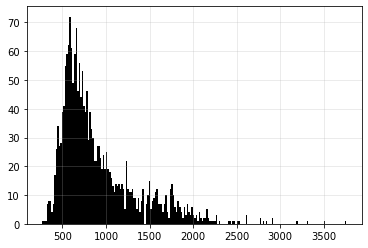

In [46]:
gp.msIntoSlot.hist(bins=200, color='k')

## single hour

In [53]:
gp.keys()

Index(['insertId', 'jsonPayload.blockHash', 'jsonPayload.blockNumber',
       'jsonPayload.contentLength', 'jsonPayload.headSlot',
       'jsonPayload.idArg', 'jsonPayload.level', 'jsonPayload.method',
       'jsonPayload.mevBoostV', 'jsonPayload.msIntoSlot', 'jsonPayload.msg',
       'jsonPayload.numTx', 'jsonPayload.proposerPubkey',
       'jsonPayload.service', 'jsonPayload.slot', 'jsonPayload.slotStartSec',
       'jsonPayload.timestampAfterAlreadyDelivered',
       'jsonPayload.timestampAfterDecode',
       'jsonPayload.timestampAfterPublishing',
       'jsonPayload.timestampAfterSignatureVerify',
       'jsonPayload.timestampBeforePublishing',
       'jsonPayload.timestampRequestStart', 'jsonPayload.ua',
       'jsonPayload.version', 'labels."compute.googleapis.com/resource_name"',
       'labels."k8s-pod/app"', 'labels."k8s-pod/pod-template-hash"',
       'labels."k8s-pod/project"', 'logName', 'receiveLocation',
       'receiveTimestamp', 'resource.labels.cluster_name',
       '

In [8]:
gp = pd.read_csv('gp-0412-89am.csv', delimiter=',')
gp = gp[['jsonPayload.slot', 'jsonPayload.ua', 'jsonPayload.mevBoostV', 'timestamp', 'jsonPayload.msIntoSlot', 'jsonPayload.slotStartSec', 'jsonPayload.timestampRequestStart', 'jsonPayload.timestampAfterDecode', 'jsonPayload.timestampAfterSignatureVerify', 'jsonPayload.proposerPubkey', 'jsonPayload.blockHash']]
gp = gp.astype({'jsonPayload.slot': 'Int64'})
gp = gp.rename(columns={'jsonPayload.slot': 'slot', 
                        'jsonPayload.msIntoSlot': 'msIntoSlot',
                        'jsonPayload.ua': 'ua',
                        'jsonPayload.mevBoostV': 'mevBoostV',
                        'jsonPayload.slotStartSec': 'start',
                        'jsonPayload.timestampRequestStart': 'req',
                        'jsonPayload.timestampAfterDecode': 'decode',
                        'jsonPayload.timestampAfterSignatureVerify': 'sig',
                        'jsonPayload.proposerPubkey': 'pk',
                        'jsonPayload.blockHash': 'hash'
                       })
gp.head()

,slot,ua,mevBoostV,timestamp,msIntoSlot,start,req,decode,sig,pk,hash
0,6206724,mev-boost/v1.5.0 okhttp/4.10.0,v1.5.0,2023-04-12T13:05:13Z,830,1681304711,1681304711825,1681304711830,1681304711832,0xa345c8a4faaf152d2d99ab1f1d50b2296c3d68bf4671...,0xaf8bf8c86fe46af549d5b2a6372dc7cb2ad22d813706...
1,6206721,mev-boost/v1.5.0 Go-http-client/1.1,v1.5.0,2023-04-12T13:04:36Z,377,1681304675,1681304675358,1681304675377,1681304675380,0xb89bdeece34d33cea1ed7a74c348b5e417cefe4bd5c5...,0xa63ac173dfa4f55c532440641bcb5dcc403a03a35013...
2,6206719,mev-boost/v1.5.0,v1.5.0,2023-04-12T13:04:13Z,1032,1681304651,1681304651873,1681304652032,1681304652034,0xa9fb48262e04d4e7c8b7c95ff269fd6de905ace5bba7...,0x16c1e7b669613703898bf67ca91c74e7ba4c7185c250...
3,6206718,mev-boost/v1.5.0,v1.5.0,2023-04-12T13:04:00Z,597,1681304639,1681304639595,1681304639597,1681304639599,0x830a363b71e1af8f5ea69f4a4c53e49cd63fb4eaa605...,0xa4089c6f337ffaea3e9a0421cf8539fb317fe56a363a...
4,6206716,mev-boost/v1.5.0 Go-http-client/1.1,v1.5.0,2023-04-12T13:03:37Z,788,1681304615,1681304615756,1681304615788,1681304615792,0x88d62235a2afa84df67f3743ee2cbd8aa691da0e519e...,0xe221e6d8cfc6323f4cbcad5206e35526f628dc74e862...


In [11]:
lb.keys()

Index(['reqSize', 'ua', 'ip', 'timestamp', 'slot_boundary'], dtype='object')

In [14]:
lb = pd.read_csv('lb-0412-89am.csv', delimiter=',')
lb = lb[['httpRequest.requestSize', 'httpRequest.userAgent', 'jsonPayload.remoteIp', 'timestamp']]
lb = lb.rename(columns={'httpRequest.requestSize': 'reqSize', 
                        'httpRequest.userAgent': 'ua',
                        'jsonPayload.remoteIp': 'ip',
                       })
lb['timestamp'] = pd.to_datetime(lb['timestamp'], format="%Y-%m-%dT%H:%M:%S.%fZ")
lb['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') - pd.Timedelta('1s') for x in lb['timestamp'].values])
lb['slot'] = np.asarray([slotFromTs(x) for x in lb['slot_boundary'].values])
lb.head()

,reqSize,ua,ip,timestamp,slot_boundary,slot
0,68135,mev-boost/v1.5.0 okhttp/4.10.0,68.183.12.3,2023-04-12 13:05:11.821515,2023-04-12 13:05:11,6206724
1,84804,mev-boost/v1.5.0 Go-http-client/1.1,34.253.221.137,2023-04-12 13:04:35.349580,2023-04-12 13:04:35,6206721
2,44419,mev-boost/v1.5.0,20.106.15.238,2023-04-12 13:04:11.815999,2023-04-12 13:04:11,6206719
3,62985,mev-boost/v1.5.0,89.149.218.12,2023-04-12 13:03:59.591950,2023-04-12 13:03:59,6206718
4,84811,mev-boost/v1.5.0 Go-http-client/1.1,13.51.48.23,2023-04-12 13:03:35.742235,2023-04-12 13:03:35,6206716


In [13]:
def slotFromTs(ts):
    unix = int(ts.astype(np.timedelta64) / np.timedelta64(1, 's'))
    slot = int((unix- 1606824023) / 12)
    return slot

In [15]:
ips = pd.merge(gp, lb, on=['slot', 'ua'])
# ips['reqArrival'] = [int(v.total_seconds()*1000) for v in ips['timestamp_y'] - ips['slot_boundary']]
ips = ips.rename(columns={'msIntoSlot': 'getPayloadArrival'})
ips = ips[['slot', 'ip', 'ua', 'getPayloadArrival', 'slot_boundary', 'reqSize', 'pk', 'hash']]
ips.head()

,slot,ip,ua,getPayloadArrival,slot_boundary,reqSize,pk,hash
0,6206724,68.183.12.3,mev-boost/v1.5.0 okhttp/4.10.0,830,2023-04-12 13:05:11,68135,0xa345c8a4faaf152d2d99ab1f1d50b2296c3d68bf4671...,0xaf8bf8c86fe46af549d5b2a6372dc7cb2ad22d813706...
1,6206721,34.253.221.137,mev-boost/v1.5.0 Go-http-client/1.1,377,2023-04-12 13:04:35,84804,0xb89bdeece34d33cea1ed7a74c348b5e417cefe4bd5c5...,0xa63ac173dfa4f55c532440641bcb5dcc403a03a35013...
2,6206719,20.106.15.238,mev-boost/v1.5.0,1032,2023-04-12 13:04:11,44419,0xa9fb48262e04d4e7c8b7c95ff269fd6de905ace5bba7...,0x16c1e7b669613703898bf67ca91c74e7ba4c7185c250...
3,6206718,89.149.218.12,mev-boost/v1.5.0,597,2023-04-12 13:03:59,62985,0x830a363b71e1af8f5ea69f4a4c53e49cd63fb4eaa605...,0xa4089c6f337ffaea3e9a0421cf8539fb317fe56a363a...
4,6206716,13.51.48.23,mev-boost/v1.5.0 Go-http-client/1.1,788,2023-04-12 13:03:35,84811,0x88d62235a2afa84df67f3743ee2cbd8aa691da0e519e...,0xe221e6d8cfc6323f4cbcad5206e35526f628dc74e862...


In [ ]:
resource.type="http_load_balancer"
httpRequest.status=200
"https://relay.ultrasound.money/eth/v1/builder/header/6206724"
jsonPayload.remoteIp="68.183.12.3"

In [3]:
from google.cloud.logging import DESCENDING, Client


In [6]:
client = Client(project='ultra-sound-relay')

/usr/local/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [ ]:
2023-04-12T13:05:11.170450Z

In [31]:
FILTER = 'resource.type="http_load_balancer" ' + \
'httpRequest.status=200 ' + \
'"https://relay.ultrasound.money/eth/v1/builder/header/6206724" ' + \
'jsonPayload.remoteIp="68.183.12.3" ' + \
'AND timestamp>=' + '\"' + '2023-04-12T13:05:11.170450Z' '\" ' + \
'AND timestamp<=' + '\"' + '2023-04-12T13:07:11.170450Z' + '\"'

In [22]:
FILTER

'resource.type="http_load_balancer" httpRequest.status=200 "https://relay.ultrasound.money/eth/v1/builder/header/6206724" jsonPayload.remoteIp="68.183.12.3" AND timestamp>="2023-04-12T13:06:11.170450Z" AND timestamp <= "2023-04-12T13:07:11.170450Z"'

In [32]:
for e in client.list_entries(filter_=FILTER):
    print(e)

StructEntry(log_name='projects/ultra-sound-relay/logs/requests', labels=None, insert_id='7s6vhef38wy4c', severity='INFO', http_request={'requestMethod': 'GET', 'requestUrl': 'https://relay.ultrasound.money/eth/v1/builder/header/6206724/0xe1918c124b7c32e41a0620105a1f53033bddfdb753fca9fc1c374deed2c16170/0xa345c8a4faaf152d2d99ab1f1d50b2296c3d68bf4671c2b136e8e1ac485b21a1ccf239e7b5fec1943e2f4a9ecdfd4c05', 'requestSize': '145', 'status': 200, 'responseSize': '1230', 'userAgent': 'mev-boost/v1.5.0 okhttp/4.10.0', 'remoteIp': '68.183.12.3', 'serverIp': '10.80.0.90', 'latency': '0.007312s'}, timestamp=datetime.datetime(2023, 4, 12, 13, 5, 11, 170450, tzinfo=datetime.timezone.utc), resource=Resource(type='http_load_balancer', labels={'zone': 'global', 'backend_service_name': 'k8s1-07224e61-default-proposer-api-80-9fd4590d', 'url_map_name': 'k8s2-um-yeqx1i6o-default-api-prod-v2-nmbopc90', 'target_proxy_name': 'k8s2-ts-yeqx1i6o-default-api-prod-v2-nmbopc90', 'forwarding_rule_name': 'k8s2-fs-yeqx1i

# SCRIPT

In [98]:
# read data from file.
dlvd = pd.read_csv('apr12-payloads.txt', delimiter='|', names=['slot','block_hash','proposer_pubkey','inserted_at'])
dlvd['inserted_at'] = pd.to_datetime(dlvd['inserted_at'], format="%Y-%m-%d%H:%M:%S.%f")
dlvd['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') - pd.Timedelta('1s') for x in dlvd['inserted_at'].values])
dlvd.head()

,slot,block_hash,proposer_pubkey,inserted_at,slot_boundary
0,6200251,0xa9919dcc29eabc8e0c967108e306dfc300d2425c7912...,0x8a13257bd79486d55e39b5edba59be7db1539789b71b...,2023-04-11 15:30:37.358157,2023-04-11 15:30:35
1,6200260,0x15116fbb7f527090d7f5776926c945b8123224ecb7d4...,0x8763a8e8f8c968cc05f782f8d90e452a1af789724081...,2023-04-11 15:32:25.193994,2023-04-11 15:32:23
2,6200263,0xf4bc26ed3cd6ce65fff3e7c249e0d8b3158e1d75c4eb...,0xb0e4825e9b0f07e407c6521d691464a03ec41352edbc...,2023-04-11 15:33:01.098459,2023-04-11 15:32:59
3,6200264,0x96a06b84bb0122783f6dc0f671ffa6c93c3b6acd6a68...,0xb2787d518339828927356da0445d0cde6cdcd3255bc1...,2023-04-11 15:33:13.160390,2023-04-11 15:33:11
4,6200265,0xdfbbca4c0b929ea48df4a736ddde6052bd4c2546c841...,0x8a446df54f9b40802ee85eb60c528c7544c8fea24292...,2023-04-11 15:33:25.186221,2023-04-11 15:33:23


In [ ]:
getPayloads = 

In [ ]:
('13.51.48.23',
 'mev-boost/v1.5.0 Go-http-client/1.1',
 '71463',
 '1.581467s',
 datetime.datetime(2023, 4, 11, 15, 30, 35, 808494, tzinfo=datetime.timezone.utc))

In [91]:
client = Client(project='ultra-sound-relay')

/usr/local/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [96]:
client.list_entries(filter_=gpFilter)

<generator object _LoggingAPI.list_entries.<locals>.log_entries_pager at 0x12152ef20>

In [129]:
client = Client(project='ultra-sound-relay')

/usr/local/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [166]:
payloads = []
for e in client.list_entries(filter_='jsonPayload.method="getPayload" AND "could not verify capella payload signature"'):
#     vals.append(int(e.payload['slot']))
#     print(e)
#     temp = e
    payloads.append(e.to_api_repr()['jsonPayload'])

In [167]:
df = pd.DataFrame(payloads)
df= df.astype({'slot': 'int32'})

In [168]:
df.head()

,proposerPubkey,timestampRequestStart,timestampAfterDecode,method,blockHash,slot,mevBoostV,slotStartSec,version,contentLength,headSlot,msIntoSlot,idArg,service,error,level,msg,ua
0,0xa9c3eff1100a226df1f8277c72bc3971dcd304a5d9f2...,1.681339e+12,1.681339e+12,getPayload,0xf592c8560d434c9a554f8b103c5c2c799b1faa3d0528...,6209543,v1.5.0,1.681339e+09,,84890.0,6209542.0,1737.0,,relay/api,None,warning,could not verify capella payload signature,mev-boost/v1.5.0 Go-http-client/1.1
1,0xa9c3eff1100a226df1f8277c72bc3971dcd304a5d9f2...,1.681339e+12,1.681339e+12,getPayload,0xf592c8560d434c9a554f8b103c5c2c799b1faa3d0528...,6209543,v1.5.0,1.681339e+09,,84890.0,6209542.0,1903.0,,relay/api,None,warning,could not verify capella payload signature,mev-boost/v1.5.0 Go-http-client/1.1
2,0xa9c3eff1100a226df1f8277c72bc3971dcd304a5d9f2...,1.681339e+12,1.681339e+12,getPayload,0xf592c8560d434c9a554f8b103c5c2c799b1faa3d0528...,6209543,v1.5.0,1.681339e+09,,84890.0,6209542.0,1570.0,,relay/api,None,warning,could not verify capella payload signature,mev-boost/v1.5.0 Go-http-client/1.1
3,0xa9c3eff1100a226df1f8277c72bc3971dcd304a5d9f2...,1.681339e+12,1.681339e+12,getPayload,0xf592c8560d434c9a554f8b103c5c2c799b1faa3d0528...,6209543,v1.5.0,1.681339e+09,,84890.0,6209542.0,2234.0,,relay/api,None,warning,could not verify capella payload signature,mev-boost/v1.5.0 Go-http-client/1.1
4,0xa9c3eff1100a226df1f8277c72bc3971dcd304a5d9f2...,1.681339e+12,1.681339e+12,getPayload,0xf592c8560d434c9a554f8b103c5c2c799b1faa3d0528...,6209543,v1.5.0,1.681339e+09,,84890.0,6209542.0,2070.0,,relay/api,None,warning,could not verify capella payload signature,mev-boost/v1.5.0 Go-http-client/1.1


In [177]:
set(df['slot'])

{6209543,
 6209609,
 6209620,
 6209643,
 6209655,
 6209723,
 6209731,
 6209875,
 6209877,
 6209885,
 6209902,
 6209920,
 6209957,
 6209967,
 6209986,
 6210036,
 6210037,
 6210054,
 6210089,
 6210103,
 6210214,
 6210402,
 6210534,
 6210726,
 6211358,
 6211845,
 6212101,
 6212166,
 6212625,
 6212769,
 6212967,
 6213249,
 6213853,
 6213855,
 6214241,
 6214321}

In [181]:
res = []
for s in sorted(set(df['slot'])):
#     if s > 6210214:
        time.sleep(0.1)
        url = 'http://57.128.92.65:3500/eth/v1/beacon/headers/{}'.format(s)
        headers = {'content-type': 'application/json'}
        r = requests.get(url, headers=headers)
        try: 
            code = r.json()['code']
            print(s, False)
            res.append((s, False))
        except KeyError:
            print(s, True)
            res.append((s, True))
res = np.asarray(res)
missed = np.asarray([v[0] for v in res if v[1] == 0])

6209543 False
6209609 False
6209620 True
6209643 False
6209655 False
6209723 False
6209731 False
6209875 False
6209877 False
6209885 True
6209902 False
6209920 False
6209957 True
6209967 False
6209986 False
6210036 False
6210037 True
6210054 False
6210089 False
6210103 False
6210214 False
6210402 True
6210534 True
6210726 True
6211358 True
6211845 True
6212101 True
6212166 True
6212625 True
6212769 True
6212967 True
6213249 True
6213853 True
6213855 True
6214241 True
6214321 True


In [171]:
res = []
for s in set(df['slot']):
    if s <= 6210214:
        time.sleep(0.5)
        url = 'https://beaconcha.in/api/v1/slot/{}'.format(s)
        headers = {'content-type': 'application/json'}
        r = requests.get(url, headers=headers)
        try: 
            if r.json()['status'] != 'OK':
                print(s, False)
                res.append((s, False))
            else:
                res.append((s, True))
                print(s, True)
        except KeyError:
            print(r.json())

6209920 False
6210054 False
6209543 False
6209957 True
6210214 False
6210089 False
6209967 False
6210103 False
6209723 False
6209986 False
6209731 False
6209609 False
6209875 False
6209620 True
6209877 False
6209885 True
6209643 False
6209902 False
6210036 False
6210037 True
6209655 False


In [172]:
res = np.asarray(res)

In [173]:
missed = [v[0] for v in res if v[1] == 0]

In [175]:
sorted(missed)

[6209543,
 6209609,
 6209643,
 6209655,
 6209723,
 6209731,
 6209875,
 6209877,
 6209902,
 6209920,
 6209967,
 6209986,
 6210036,
 6210054,
 6210089,
 6210103,
 6210214]

In [176]:
for i in sorted(missed):
    print(i)

6209543
6209609
6209643
6209655
6209723
6209731
6209875
6209877
6209902
6209920
6209967
6209986
6210036
6210054
6210089
6210103
6210214


In [150]:
temp.to_api_repr()['jsonPayload']

{'proposerPubkey': '0xa9c3eff1100a226df1f8277c72bc3971dcd304a5d9f251a6ce12e0e3ec5f1443288dd6062e6735da89ec86da1395be57',
 'timestampRequestStart': 1681338540707.0,
 'timestampAfterDecode': 1681338540737.0,
 'method': 'getPayload',
 'blockHash': '0xf592c8560d434c9a554f8b103c5c2c799b1faa3d0528385f265ef650c00ecfa4',
 'slot': 6209543.0,
 'slotStartSec': 1681338539.0,
 'mevBoostV': 'v1.5.0',
 'contentLength': 84890.0,
 'version': '',
 'headSlot': 6209542.0,
 'msIntoSlot': 1737.0,
 'idArg': '',
 'service': 'relay/api',
 'level': 'warning',
 'error': None,
 'msg': 'could not verify capella payload signature',
 'ua': 'mev-boost/v1.5.0 Go-http-client/1.1'}

In [143]:
set(vals)

{6209543,
 6209609,
 6209620,
 6209643,
 6209655,
 6209723,
 6209731,
 6209875,
 6209877,
 6209885,
 6209902,
 6209920,
 6209957,
 6209967,
 6209986,
 6210036,
 6210037,
 6210054,
 6210089,
 6210103,
 6210214}

In [ ]:
'jsonPayload.method="getPayload" AND "could not verify capella payload signature"'

In [124]:
getPayloads = pd.DataFrame(columns=['slot', 'ip', 'ua', 'reqTime'])
for v in dlvd.iterrows():
    if v[1]['slot'] > 6201424:
        time.sleep(1)
        # get successful getPayload calls.
        inAt = v[1]['inserted_at']
        print('querying logs for slot {} inserted at {}'.format(v[1]['slot'], v[1]['inserted_at']), end='\r')
        gpFilter = '"https://relay.ultrasound.money/eth/v1/builder/blinded_block" ' + \
                   'AND timestamp>=' + '\"' + (inAt - pd.Timedelta('12s')).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\" ' + \
                   'AND timestamp<=' + '\"' + (inAt).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\"'
        entries = False
        for e in client.list_entries(filter_=gpFilter):
            entries = True
            out = {}
            out['slot'] = v[1]['slot']
            out['ip'] = e.http_request['remoteIp']
            out['ua'] = e.http_request['userAgent']
            out['reqTime'] = e.timestamp 
            getPayloads = getPayloads.append(out, ignore_index=True)
        if not entries:
            print("\n *** no entries found for slot: {}".format(v[1]['slot']))
            print(gpFilter)
            break

In [125]:
getPayloads

,slot,ip,ua,reqTime
0,6201426,80.190.129.50,Go-http-client/1.1,2023-04-11 19:25:35.015804+00:00
1,6201431,34.150.1.42,mev-boost/v1.5.0 Go-http-client/1.1,2023-04-11 19:26:36.085117+00:00
2,6201433,89.149.218.12,mev-boost/v1.5.0 okhttp/4.10.0,2023-04-11 19:26:59.839549+00:00
3,6201437,18.217.98.216,mev-boost/v1.5.0 okhttp/4.10.0,2023-04-11 19:27:47.418485+00:00
4,6201438,89.149.218.12,mev-boost/v1.5.0,2023-04-11 19:27:59.648012+00:00
...,...,...,...,...
2123,6207465,142.132.208.242,mev-boost/v1.5.0,2023-04-12 15:33:23.562227+00:00
2124,6207473,142.132.159.189,mev-boost/v1.5.0,2023-04-12 15:34:59.893000+00:00
2125,6207476,51.91.130.226,mev-boost/v1.5.0,2023-04-12 15:35:35.761801+00:00
2126,6207477,51.91.80.116,mev-boost/v1.5.0 Go-http-client/1.1,2023-04-12 15:35:47.965914+00:00


In [ ]:
pd.to_csv(paylogetPayloads)

In [127]:
getPayloadsFull = pd.merge(getPayloads, dlvd, on='slot')
getPayloadsFull

,slot,ip,ua,reqTime,block_hash,proposer_pubkey,inserted_at,slot_boundary
0,6201426,80.190.129.50,Go-http-client/1.1,2023-04-11 19:25:35.015804+00:00,0x57e0a10df34be66c7a050d334386ec905947c2a17531...,0x8bed47be84bd74af557f822cac2cdb301997b183330d...,2023-04-11 19:25:37.458580,2023-04-11 19:25:35
1,6201431,34.150.1.42,mev-boost/v1.5.0 Go-http-client/1.1,2023-04-11 19:26:36.085117+00:00,0x56acf066cbb7800236fc9b593904d412d8745ea72daa...,0xaaddd9f064e5627070a4fd6c607760c8b9e48403e2be...,2023-04-11 19:26:38.446741,2023-04-11 19:26:35
2,6201433,89.149.218.12,mev-boost/v1.5.0 okhttp/4.10.0,2023-04-11 19:26:59.839549+00:00,0x0e8201f6844555be7e428a8d8f6c014cf2be46c5502d...,0xa74ba3bd83fad82e37dadbcce45c844b8515114c0572...,2023-04-11 19:27:01.381098,2023-04-11 19:26:59
3,6201437,18.217.98.216,mev-boost/v1.5.0 okhttp/4.10.0,2023-04-11 19:27:47.418485+00:00,0xfc133f42b8b0e13f79709103870fd8f667f3caf866ec...,0x953f2da15207b97deebd21209e326f17650e65477e79...,2023-04-11 19:27:49.050850,2023-04-11 19:27:47
4,6201438,89.149.218.12,mev-boost/v1.5.0,2023-04-11 19:27:59.648012+00:00,0x6dca013bd041f73c49d4fccdc4c53707c4a1e48c7040...,0xa7ef25fdd507b5edf64f9cdbacae3c05fd719295bbb5...,2023-04-11 19:28:01.116487,2023-04-11 19:27:59
...,...,...,...,...,...,...,...,...
2123,6207465,142.132.208.242,mev-boost/v1.5.0,2023-04-12 15:33:23.562227+00:00,0xd07e4903c9f64d38c665cda98f8547c367bb3ffb2ec0...,0xa8f6c36c594cfbe6443b1ec750d88b1b5a693926e3cc...,2023-04-12 15:33:24.974809,2023-04-12 15:33:23
2124,6207473,142.132.159.189,mev-boost/v1.5.0,2023-04-12 15:34:59.893000+00:00,0xb902a9294a4ef14c07a2d9848acf556afd098c6fbbcb...,0x8d2f92043e1999d24a9ac6672e1a1d12b221a9188757...,2023-04-12 15:35:01.448264,2023-04-12 15:34:59
2125,6207476,51.91.130.226,mev-boost/v1.5.0,2023-04-12 15:35:35.761801+00:00,0xc0410ecda28fbe4a399e68d31b7e4a13cdf7ae498791...,0x8fb8b1ca176b21f346d771b4f487d81638850b55ea7e...,2023-04-12 15:35:37.262222,2023-04-12 15:35:35
2126,6207477,51.91.80.116,mev-boost/v1.5.0 Go-http-client/1.1,2023-04-12 15:35:47.965914+00:00,0x182cc5a0b0cc1315cec955a9ec58c982fc857a6b6c30...,0xa0b50c5f47c282917cb3e39d0f457732c471d277c0f9...,2023-04-12 15:35:50.274764,2023-04-12 15:35:47


In [128]:
getPayloadsFull.to_csv('gpFullSecond.csv')

In [79]:
# get successful getPayload calls.
gpFilter = 'httpRequest.status=200 AND ' + \
           '"https://relay.ultrasound.money/eth/v1/builder/blinded_block" ' + \
           'AND timestamp>=' + '\"' + (out - pd.Timedelta('12s')).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\" ' + \
           'AND timestamp<=' + '\"' + (out).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\"'
gpFilter

'httpRequest.status=200 AND "https://relay.ultrasound.money/eth/v1/builder/blinded_block" AND timestamp>="2023-04-11T15:30:25.358157Z" AND timestamp<="2023-04-11T15:30:37.358157Z"'

In [81]:
client = Client(project='ultra-sound-relay')

/usr/local/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [83]:
for e in client.list_entries(filter_=gpFilter):
    print(e)
    out = e

StructEntry(log_name='projects/ultra-sound-relay/logs/requests', labels=None, insert_id='epiam4f808gnm', severity='INFO', http_request={'requestMethod': 'POST', 'requestUrl': 'https://relay.ultrasound.money/eth/v1/builder/blinded_blocks', 'requestSize': '84816', 'status': 200, 'responseSize': '71463', 'userAgent': 'mev-boost/v1.5.0 Go-http-client/1.1', 'remoteIp': '13.51.48.23', 'serverIp': '10.80.1.63', 'latency': '1.581467s'}, timestamp=datetime.datetime(2023, 4, 11, 15, 30, 35, 808494, tzinfo=datetime.timezone.utc), resource=Resource(type='http_load_balancer', labels={'backend_service_name': 'k8s1-07224e61-default-proposer-api-80-9fd4590d', 'zone': 'global', 'url_map_name': 'k8s2-um-yeqx1i6o-default-api-prod-v2-nmbopc90', 'target_proxy_name': 'k8s2-ts-yeqx1i6o-default-api-prod-v2-nmbopc90', 'forwarding_rule_name': 'k8s2-fs-yeqx1i6o-default-api-prod-v2-nmbopc90', 'project_id': 'ultra-sound-relay'}), trace='projects/ultra-sound-relay/traces/afcdede08b7332dff3fb4cfd2c51140b', span_id='

In [86]:
out

StructEntry(log_name='projects/ultra-sound-relay/logs/requests', labels=None, insert_id='epiam4f808gnm', severity='INFO', http_request={'requestMethod': 'POST', 'requestUrl': 'https://relay.ultrasound.money/eth/v1/builder/blinded_blocks', 'requestSize': '84816', 'status': 200, 'responseSize': '71463', 'userAgent': 'mev-boost/v1.5.0 Go-http-client/1.1', 'remoteIp': '13.51.48.23', 'serverIp': '10.80.1.63', 'latency': '1.581467s'}, timestamp=datetime.datetime(2023, 4, 11, 15, 30, 35, 808494, tzinfo=datetime.timezone.utc), resource=Resource(type='http_load_balancer', labels={'backend_service_name': 'k8s1-07224e61-default-proposer-api-80-9fd4590d', 'zone': 'global', 'url_map_name': 'k8s2-um-yeqx1i6o-default-api-prod-v2-nmbopc90', 'target_proxy_name': 'k8s2-ts-yeqx1i6o-default-api-prod-v2-nmbopc90', 'forwarding_rule_name': 'k8s2-fs-yeqx1i6o-default-api-prod-v2-nmbopc90', 'project_id': 'ultra-sound-relay'}), trace='projects/ultra-sound-relay/traces/afcdede08b7332dff3fb4cfd2c51140b', span_id='

In [88]:
out.http_request['remoteIp'], out.http_request['userAgent'], out.http_request['responseSize'], out.http_request['latency'], out.timestamp 

('13.51.48.23',
 'mev-boost/v1.5.0 Go-http-client/1.1',
 '71463',
 '1.581467s',
 datetime.datetime(2023, 4, 11, 15, 30, 35, 808494, tzinfo=datetime.timezone.utc))